/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Train: 2017-01-01 → 2023-12-01 | rows=45
Test : 2024-01-01  → 2024-12-01  | rows=12

Random Forest — YoY target (2024 test)
R²    : -0.198
MAE   : 10.71 pp
RMSE  : 13.13 pp
SMAPE : 41.19%

XGBoost — YoY target (2024 test)
R²    : -0.841
MAE   : 12.39 pp
RMSE  : 16.27 pp
SMAPE : 50.88%

Random Forest — Reconstructed ARRIVALS (2024 test)
R²    : -0.419
MAE   : 268,903
RMSE  : 365,587
MAPE  : 8.63%

XGBoost — Reconstructed ARRIVALS (2024 test)
R²    : -0.357
MAE   : 281,823
RMSE  : 357,469
MAPE  : 9.20%


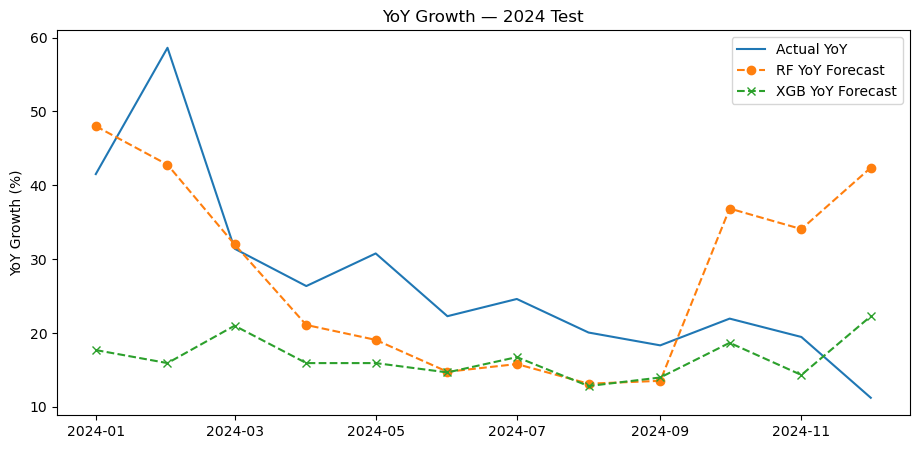

In [19]:
# --- 1) Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# --- 2) Load & monthly index
df = pd.read_csv("/Users/aman/Downloads/bangkok_2015_2024_final.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date').asfreq('MS')

# --- 3) Build YoY (%) for arrivals + exogenous
for col in ['visitor_arrivals','hotel_occupancy','google_trends']:
    df[f'{col}_yoy'] = (df[col] / df[col].shift(12) - 1.0) * 100

# Keep lag12 arrivals for reconstructing arrival forecasts from YoY predictions
df['arrivals_lag12'] = df['visitor_arrivals'].shift(12)

# --- 4) Winsorize YoY to reduce extreme spikes (cap at 1st/99th pct)
def winsorize(s, lo=0.01, hi=0.99):
    ql, qh = s.quantile(lo), s.quantile(hi)
    return s.clip(lower=ql, upper=qh)

for col in ['visitor_arrivals_yoy','hotel_occupancy_yoy','google_trends_yoy']:
    df[col] = winsorize(df[col].dropna()).reindex(df.index)

# --- 5) Create YoY lag & rolling features (on arrivals_yoy)
for L in [1,3,6,12]:
    df[f'yoy_lag{L}'] = df['visitor_arrivals_yoy'].shift(L)

df['yoy_roll3'] = df['visitor_arrivals_yoy'].rolling(3).mean()
df['yoy_roll6'] = df['visitor_arrivals_yoy'].rolling(6).mean()

# --- 6) Modeling frame
feature_cols = [
    'hotel_occupancy_yoy','google_trends_yoy',
    'yoy_lag1','yoy_lag3','yoy_lag6','yoy_lag12',
    'yoy_roll3','yoy_roll6'
]
target_col = 'visitor_arrivals_yoy'

df_mod = df.dropna(subset=feature_cols + [target_col, 'arrivals_lag12', 'visitor_arrivals']).copy()

X = df_mod[feature_cols]
y = df_mod[target_col]

# --- 7) Split: Train = 2016–2019 + Apr–Dec 2023, Test = 2024
train_mask = ((df_mod.index.year >= 2016) & (df_mod.index.year <= 2019)) | \
             ((df_mod.index.year == 2023) & (df_mod.index.month >= 4))
test_mask  = (df_mod.index.year == 2024)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

print(f"Train: {y_train.index.min().date()} → {y_train.index.max().date()} | rows={len(y_train)}")
print(f"Test : {y_test.index.min().date()}  → {y_test.index.max().date()}  | rows={len(y_test)}")

# --- 8) Fit two models: Random Forest & XGBoost
rf = RandomForestRegressor(
    n_estimators=600, max_depth=None, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

xgb = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
xgb.fit(X_train, y_train)

# --- 9) Predict YoY
pred_rf  = rf.predict(X_test)
pred_xgb = xgb.predict(X_test)

# --- 10) YoY metrics
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom != 0
    return float(np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100.0)

def report(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(np.mean((y_true - y_pred)**2))
    print(f"\n{name} — YoY target (2024 test)")
    print(f"R²    : {r2:.3f}")
    print(f"MAE   : {mae:.2f} pp")
    print(f"RMSE  : {rmse:.2f} pp")
    print(f"SMAPE : {smape(y_true, y_pred):.2f}%")
    return r2

r2_rf  = report("Random Forest", y_test, pred_rf)
r2_xgb = report("XGBoost",      y_test, pred_xgb)

# --- 11) Reconstruct ARRIVALS forecasts from YoY predictions (optional, for interpretability)
# arrivals_pred_t = arrivals_{t-12} * (1 + yoy_pred_t/100)
arr_lag12_test = df_mod.loc[test_mask, 'arrivals_lag12']
arr_actual     = df_mod.loc[test_mask, 'visitor_arrivals']

arr_pred_rf  = arr_lag12_test * (1 + pred_rf/100.0)
arr_pred_xgb = arr_lag12_test * (1 + pred_xgb/100.0)

def report_arrivals(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(np.mean((y_true - y_pred)**2))
    mape = float((np.abs((y_true - y_pred)/y_true).replace([np.inf,-np.inf], np.nan).dropna()*100).mean())
    print(f"\n{name} — Reconstructed ARRIVALS (2024 test)")
    print(f"R²    : {r2:.3f}")
    print(f"MAE   : {mae:,.0f}")
    print(f"RMSE  : {rmse:,.0f}")
    print(f"MAPE  : {mape:.2f}%")

report_arrivals("Random Forest", arr_actual, arr_pred_rf)
report_arrivals("XGBoost",       arr_actual, arr_pred_xgb)

# --- 12) (Optional) Plot YoY predictions for 2024
plt.figure(figsize=(11,5))
plt.plot(y_test.index, y_test.values, label="Actual YoY")
plt.plot(y_test.index, pred_rf,  label="RF YoY Forecast", linestyle="--", marker="o")
plt.plot(y_test.index, pred_xgb, label="XGB YoY Forecast", linestyle="--", marker="x")
plt.title("YoY Growth — 2024 Test")
plt.ylabel("YoY Growth (%)")
plt.legend()
plt.show()